# 学習曲線と検証曲線によるアルゴリズムの診断

In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# ジュピターノートブック上でグラフを表示させるための処理
%matplotlib inline

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## Breast Cancer Wisconsinデータセットの読み込み

このデータセットには、悪性腫瘍細胞と良性腫瘍細胞の569のサンプルが含まれている。

このデータセットの最初の2つの列には、サンプルの一意なIDとそれに対応する診断結果が含まれている。診断結果の`M`は悪性(malignant)を示し、`B`は良性(benign)を示す。

3列目から32列目には、細胞核のデジタル画像から算出された30個の実数値の特徴量が含まれている。

これらは腫瘍が良性か悪性かを予測するモデルの構築に利用できる。

In [2]:
# データセットの読み込み
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)
# 30個の特徴量をnumpy配列のオブジェクトXに割り当てる。
# LabelEncoderを使って、元のクラスラベルの文字列表現(MおよびB)を整数に変換する。
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
# 配列yに格納されたクラスラベル（診断結果）エンコードした後は、悪性腫瘍はクラス1、良性腫瘍はクラス2で表される。
y = le.fit_transform(y)
print(y[:5])
print(le.fit_transform(['M', 'B']))

# エンコード後のデータセットをトレーニングデータセット（データの80%）とテストデータセット（データの20%）に分割する。
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

[1 1 1 1 1]
[1 0]


## 学習曲線を使ってバイアスとバリアンスの問題を診断する

トレーニングセットに対してモデルの自由度が高かったり、パラメータが多すぎたりする場合、モデルはトレーニングデータを過学習する傾向にあり、未知のデータに対してうまく汎化されない。

この現象を防ぐための対策として以下がある。
- トレーニングデータセットのサイズの関数として、モデルのトレーニングと検証の正解率をプロットすると、モデルのバリアンスやバイアスが高いかどうか、そしてデータをさらに集めることがこの問題の解決に役立つかどうかを簡単に突き止めることができる。

### scikit-learnの学習曲線関数を使ったモデルの評価方法

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

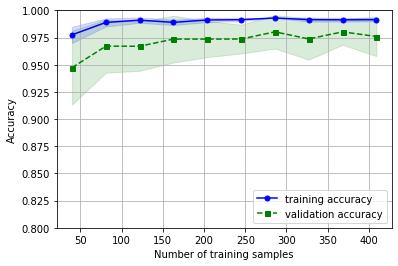

In [7]:
pipe_lr = Pipeline([('scl', StandardScaler()), ('clf', LogisticRegression(penalty='l2', random_state=0))])

# learning_curve関数で交差検証による正解率の算出
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, 
                                                                                                 X=X_train, 
                                                                                                 y=y_train, 
                                                                                                 train_sizes=np.linspace(0.1, 1.0, 10), 
                                                                                                 cv=10, 
                                                                                                 n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')

# fill_between関数で平均+/-標準偏差の幅を塗りつぶす
# トレーニングデータのサイズ train_sizes、透明度alpha、カラー'blue'を引数に指定
plt.fill_between(train_sizes, (train_mean + train_std), (train_mean - train_std), alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, (test_mean + test_std), (test_mean - test_std), alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

⬆︎

学習曲線の生成時に使用されるトレーニングサンプルの絶対数またはそう対数を制御するには、learning_curve関数のtrain_size引数を使用する。ここでは、train_sizes=np.linspace(0.1, 1.0, 10)に設定することで、トレーニングデータセットのサイズに合わせて等間隔となる10個の相対的な値を使用している。

k=10はcv引数を使って設定する。

評価のバリアンスを示すために、fill_between関数を使って正解率の標準偏差を色の帯としてグラフに追加している。

## 検証曲線を使って過学習と学習不足を明らかにする

検証曲線は、過学習や学習不足としった問題を特定することにより、モデルの性能を改善するのに役立つ。

検証曲線は学習曲線に関連しているが、トレーニングとテストの正解率をサンプルサイズの関数としてプロットするのではなく、サンプルサイズの代わりにモデルのパラメータの値を変化させる。

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

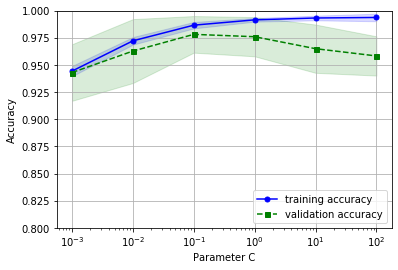

In [11]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

# validation_curve関数によりモデルのパラメータを変化させ、交差検証による正解率を算出
# clf_CはLogisticRegressionオブジェクトのパラメータ
train_scores, test_scores = validation_curve(estimator=pipe_lr,
                                                                               X=X_train,
                                                                               y=y_train,
                                                                               param_name='clf__C',
                                                                               param_range=param_range,
                                                                               cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, (train_mean + train_std), (train_mean - train_std), alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, (test_mean + test_std), (test_mean - test_std), alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()